# Recommendation Systems with TensorFlow

Outline
- Exploring the MovieLens Data 
- Preliminaries 
- Training a matrix factorization model 
- Inspecting the Embeddings 
- Regularization in matrix factorization 
- Softmax model training 

http://files.grouplens.org/datasets/movielens/

In [3]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
import altair as alt
import datapane as dp
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
tf.compat.v1.enable_eager_execution()
tf.config.run_functions_eagerly(True)
# tf.disable_v2_behavior()
# tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

In [6]:
input_file_path = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/raw/'
output_files = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/outputs'

In [7]:
def read_file(file_name):
    return pd.read_csv(open(f"{input_file_path}/{file_name}", 'r'))

In [8]:
def write_file(df,file_name):
    return df.to_csv(f"{output_files}/{file_name}", index=False)

In [9]:
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

In [10]:
def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

In [11]:
pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [12]:
alt.data_transformers.enable('default', max_rows=None)
# alt.renderers.enable('jupyterlab')

DataTransformerRegistry.enable('default')

# Data Exploration (users, movies, and ratings).

## Users

In [13]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

In [14]:
file_name = 'ml-100k/u.user'

In [15]:
users = pd.read_csv(f"{input_file_path}/{file_name}"
    , sep='|', names=users_cols, encoding='latin-1')

In [16]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [17]:
users.describe(include='all')

,user_id,age,sex,occupation,zip_code
count,943.000,943.000,943,943,943
unique,NaN,NaN,2,21,795
top,NaN,NaN,M,student,55414
freq,NaN,NaN,670,196,9
mean,472.000,34.052,NaN,NaN,NaN
...,...,...,...,...,...
min,1.000,7.000,NaN,NaN,NaN
25%,236.500,25.000,NaN,NaN,NaN
50%,472.000,31.000,NaN,NaN,NaN
75%,707.500,43.000,NaN,NaN,NaN


In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   sex         943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [19]:
# Unique values in each column
for column in users.columns:
    print(column, len(users[column].unique()))

user_id 943
age 61
sex 2
occupation 21
zip_code 795


In [20]:
users.isnull().any()

user_id       False
age           False
sex           False
occupation    False
zip_code      False
dtype: bool

In [21]:

profile = ProfileReport(users, title="Pandas Profiling Report for movielense_user data",
                   dataset={
        "description": "This profiling report was generated for End of Module Project for UoL",
    },)
profile.to_file("user_analysis.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Ratings

In [22]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
file_name = 'ml-100k/u.data'
ratings = pd.read_csv(f"{input_file_path}/{file_name}", sep='\t', names=ratings_cols, encoding='latin-1')

In [23]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [24]:
profile = ProfileReport(ratings, title="Pandas Profiling Report for movielense_user_rating data",
                   dataset={
        "description": "This profiling report was generated for End of Module Project for UoL",
    },)
profile.to_file("rating_analysis.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Genre

In [25]:
genre_cols = ['title', 'id',]
file_name = 'ml-100k/u.genre'
genre = pd.read_csv(f"{input_file_path}/{file_name}", sep='|', names=genre_cols, encoding='latin-1')

In [26]:
genre.head()

,title,id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [27]:
genre_c_name=list(genre['title'])

## Movies

In [28]:
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_c_name
file_name = 'ml-100k/u.item'
movies = pd.read_csv(f"{input_file_path}/{file_name}", sep='|', names=movies_cols, encoding='latin-1')

In [29]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [30]:
profile = ProfileReport(movies, title="Pandas Profiling Report for movielense_movie data",
                   dataset={
        "description": "This profiling report was generated for End of Module Project for UoL",
    },)
profile.to_file("movie_analysis.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# Since the ids start at 1, we shift them to start at 0.

In [32]:
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [33]:
users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [34]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995


In [35]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.000,881250949
1,185,301,3.000,891717742
2,21,376,1.000,878887116
3,243,50,2.000,880606923
4,165,345,1.000,886397596


In [36]:
# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_c_name].sum().to_dict()

In [37]:
genre_occurences

{'unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 "Children's": 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [38]:
# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

In [39]:
mark_genres(movies, genre_c_name)

In [40]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,1995,Children's,Animation-Children's-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Crime-Drama-Thriller


In [41]:
# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [42]:
movielens .head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.000,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.000,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,0,0,1997,Action,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.000,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,0,0,0,1996,Comedy,Comedy-Romance,49,M,writer,55105
3,195,24,4.000,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.000,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


In [43]:
profile = ProfileReport(movielens, title="Pandas Profiling Report for movielense data",
                   dataset={
        "description": "This profiling report was generated for End of Module Project for UoL",
    },)
profile.to_file("movielens_analysis.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

In [45]:
movies_ratings

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,rating count,rating mean
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,1995,Children's,Animation-Children's-Comedy,452,3.878
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,1,0,0,1995,Thriller,Action-Adventure-Thriller,131,3.206
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,1,0,0,1995,Thriller,Thriller,90,3.033
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama,209,3.550
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,1,0,0,1995,Thriller,Crime-Drama-Thriller,86,3.302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,1998,Drama,Drama,1,1.000
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,1,0,1,0,0,1998,Romance,Romance-Thriller,1,3.000
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,1,0,0,0,0,1998,Drama,Drama-Romance,1,2.000
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,1994,Comedy,Comedy,1,3.000


# Utility functions 

In [46]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

## Utility to build sparse tensor.
A sparse tensor is a dataset in which most of the entries are zero, one such example would be a large diagonal matrix. (which has many zero elements). It does not store the whole values of the tensor object but stores the non-zero values and the corresponding coordinates of them. Sparse tensor storage formats allow us to only store non-zero values thereby reducing storage requirements and eliminating unnecessary silent computations involving zero values.)
 Here are its main attributes:

    - vals (numpy.ndarray) A 1-dimensional array of non-zero values of the sparse tensor.
    - subs (numpy.ndarray) A 2-dimensional array of coordinates of the values in vals.
    - shape(tuple)


In [169]:
# Utility to build sparse tensor.

def build_rating_sparse_tensor(ratings_df):
    """
    Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
    Returns:
    A tf.SparseTensor representing the ratings matrix.
    """
    indices = ratings_df[['user_id','movie_id']].values

    values = ratings_df['rating'].values
    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

# Collaborative Filtering Recommendations
Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

You can solve this quadratic problem through Singular Value Decomposition (SVD) of the matrix. However, SVD is not a great solution either, because in real applications, the matrix may be very sparse. For example, think of all the videos on YouTube compared to all the videos a particular user has viewed. The solution UV^T(which corresponds to the model's approximation of the input matrix) will likely be close to zero, leading to poor generalization performance.

In contrast, Weighted Matrix Factorization decomposes the objective into the following two sums:

- A sum over observed entries.
- A sum over unobserved entries (treated as zeroes).

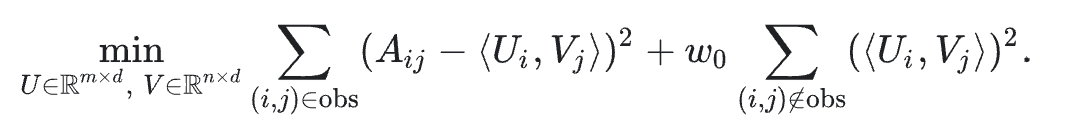

Here, 
 w0 is a hyperparameter that weights the two terms so that the objective is not dominated by one or the other. Tuning this hyperparameter is very important.



### Matrix factorisation using small example.

In [48]:
d = {'user_id': [0,0,1,2,2], 'movie_id': [0,1,1,2,3],'ratings': [3,1,5,2,5]}

In [49]:
df = pd.DataFrame(data=d)
df

,user_id,movie_id,ratings
0,0,0,3
1,0,1,1
2,1,1,5
3,2,2,2
4,2,3,5


In [50]:
indices = df[['user_id','movie_id']].values
indices

array([[0, 0],
       [0, 1],
       [1, 1],
       [2, 2],
       [2, 3]])

In [51]:
values = df['ratings'].values

In [52]:
values

array([3, 1, 5, 2, 5])

In [53]:
users.shape[0]
movies.shape[0]

943

1682

In [54]:
sparse_rating_t = tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[4, 4])

In [55]:
sparse_rating_t

SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 1]
 [2 2]
 [2 3]], shape=(5, 2), dtype=int64), values=tf.Tensor([3 1 5 2 5], shape=(5,), dtype=int64), dense_shape=tf.Tensor([4 4], shape=(2,), dtype=int64))

In [56]:
sparse_rating_t.indices

<tf.Tensor: shape=(5, 2), dtype=int64, numpy=
array([[0, 0],
       [0, 1],
       [1, 1],
       [2, 2],
       [2, 3]])>

In [57]:
# value at position index 2 -[1,5] and a specific column
sparse_rating_t.indices[2,1]

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [58]:
# value at position index 2 -[1,5] and all columns
sparse_rating_t.indices[2,:]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>

In [59]:
# value at all indices and all columns
sparse_rating_t.indices[:,:]

<tf.Tensor: shape=(5, 2), dtype=int64, numpy=
array([[0, 0],
       [0, 1],
       [1, 1],
       [2, 2],
       [2, 3]])>

In [60]:
# value at all indices and a specific column
sparse_rating_t.indices[:,1]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 1, 2, 3])>

In [61]:
sparse_rating_t.indices[:, 0]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 1, 2, 2])>

In [62]:
params = tf.constant([[0, 1.0, 2.0],
                      [10.0, 11.0, 12.0],
                      [20.0, 21.0, 22.0],
                      [30.0, 31.0, 32.0]])

In [63]:
tf.gather(params, indices=[3,2]).numpy()

array([[30., 31., 32.],
       [20., 21., 22.]], dtype=float32)

In [64]:
u_emb_raw = {'user_id': [0,1,2,3], 'dim1': [0,1,0,1],'dim2': [1,1,0,1],'dim3': [1,1,1,1],'dim4': [0,1,0,1],'dim5': [0,1,0,1],}

In [65]:
df_u = pd.DataFrame(data=u_emb_raw)

In [66]:
df_u

,user_id,dim1,dim2,dim3,dim4,dim5
0,0,0,1,1,0,0
1,1,1,1,1,1,1
2,2,0,0,1,0,0
3,3,1,1,1,1,1


In [67]:
df_u.shape

(4, 6)

In [68]:
u_emb = tf.convert_to_tensor(df_u)

In [69]:
u_emb

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 1, 0, 0],
       [3, 1, 1, 1, 1, 1]])>

In [70]:
m_emb_raw = {'movie_id': [0,1,2,3], 'dim1': [0,1,0,1],'dim2': [1,1,0,1],'dim3': [0,1,0,1],'dim4': [1,1,1,1],'dim5': [0,1,1,1],}

In [71]:
df_m = pd.DataFrame(data=m_emb_raw)

In [72]:
m_emb = tf.convert_to_tensor(df_m)

In [73]:
m_emb

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 0, 1, 1],
       [3, 1, 1, 1, 1, 1]])>

In [74]:
u_emb

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 1, 0, 0],
       [3, 1, 1, 1, 1, 1]])>

In [75]:
sparse_rating_t.indices[:, 0]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 1, 2, 2])>

In [76]:
tf.gather(u_emb, sparse_rating_t.indices[:, 0])
# repeats the number of u_emb rows depending on the sparse_rating_t i- user id

<tf.Tensor: shape=(5, 6), dtype=int64, numpy=
array([[0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 1, 0, 0],
       [2, 0, 0, 1, 0, 0]])>

In [77]:
m_emb

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 0, 1, 1],
       [3, 1, 1, 1, 1, 1]])>

In [78]:
sparse_rating_t.indices[:, 1]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 1, 2, 3])>

In [79]:
tf.gather(m_emb, sparse_rating_t.indices[:, 1])

<tf.Tensor: shape=(5, 6), dtype=int64, numpy=
array([[0, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 0, 1, 1],
       [3, 1, 1, 1, 1, 1]])>

In [80]:

tf.gather(u_emb, sparse_rating_t.indices[:, 0]) * tf.gather(m_emb, sparse_rating_t.indices[:, 1])

<tf.Tensor: shape=(5, 6), dtype=int64, numpy=
array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [4, 0, 0, 0, 0, 0],
       [6, 0, 0, 1, 0, 0]])>

In [81]:
# sum all the elements
predictions = tf.reduce_sum(tf.gather(u_emb, sparse_rating_t.indices[:, 0]) * tf.gather(m_emb, sparse_rating_t.indices[:, 1]),axis=1)

In [82]:
predictions

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 2, 6, 4, 7])>

In [83]:
sparse_rating_t.values

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 1, 5, 2, 5])>

In [84]:
loss = tf.losses.mean_squared_error(sparse_rating_t.values, predictions)

In [85]:
loss

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [86]:
loss.numpy()

2

### Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.


### Recommendation using added values (optional)

In [ ]:
# Add a record for the user
users.head()
last_id = users.index.values.max()
users.loc[last_id+1] = [last_id+1,42,"F","technician","34556"]

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [ ]:
users.tail()

,user_id,age,sex,occupation,zip_code
939,939,32,M,administrator,02215
940,940,20,M,student,97229
941,941,48,F,librarian,78209
942,942,22,M,student,77841
943,943,42,F,technician,34556


In [ ]:
# Add the ratings by this user
ratings.tail()
last_id = ratings.index.values.max()
ratings.loc[last_id+1] = ['943','275',2.000,880606923]
ratings.loc[last_id+2] = ['943','225',2.000,880606923]
ratings.loc[last_id+3] = ['943','241',5.000,880606923]

,user_id,movie_id,rating,unix_timestamp
99995,879,475,3.000,880175444
99996,715,203,5.000,879795543
99997,275,1089,1.000,874795795
99998,12,224,2.000,882399156
99999,11,202,3.000,879959583


In [ ]:
#ratings= ratings.drop([ratings.index[100000],ratings.index[100001],ratings.index[100002]])

In [ ]:
ratings.tail()

,user_id,movie_id,rating,unix_timestamp
99998,12,224,2.000,882399156
99999,11,202,3.000,879959583
100000,943,275,2.000,880606923
100001,943,225,2.000,880606923
100002,943,241,5.000,880606923


In [88]:
def sparse_mean_square_error_obs_and_unobserved(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  # ========================= Complete this section ============================
    #  Matrix multiplication
  predictions = tf.gather_nd(
  tf.math.multiply(user_embeddings, movie_embeddings, transpose_b=True),
  sparse_ratings.indices)
  loss = tf.keras.losses.MeanSquaredError(sparse_ratings.values, predictions)
  return loss

  # ============================================================================

Note: One approach is to compute the full prediction matrix  𝑈𝑉⊤ , then gather the entries corresponding to the observed pairs. The memory cost of this approach is  𝑂(𝑁𝑀) . For the MovieLens dataset, this is fine, as the dense  𝑁×𝑀  matrix is small enough to fit in memory ( 𝑁=943 ,  𝑀=1682 ).

Another approach (given in the alternate solution below) is to only gather the embeddings of the observed pairs, then compute their dot products. The memory cost is  𝑂(|Ω|𝑑)  where  𝑑  is the embedding dimension. In our case,  |Ω|=105 , and the embedding dimension is on the order of  10 , so the memory cost of both methods is comparable. But when the number of users or movies is much larger, the first approach becomes infeasible.

In [89]:
def sparse_mean_square_error_observed_pairs_only(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

# III. Training a Matrix Factorization model
This is a simple class to train a matrix factorization model using stochastic gradient descent.
The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```

### Build a Matrix Factorization model and train it
| Optimiser   | Advantages  | Disadvantages    |
| ----------- | ----------- |----------------------|
| SGD           | - Very flexible—can use other loss functions.|- Slower—does not converge as quickly.
|               |- Can be parallelized. | - Harder to handle the unobserved entries (need to use negative sampling or gravity).|
| WALS           | - Converges faster than SGD|- Reliant on Loss Squares only.
|               |- Can be parallelized. | |
|               |- Easier to handle unobserved entries. | |


Steps for matrix factorisation 
- Split the dataset in train and test
- Build sparse tensor for each of the dataset.
 
- To begin with initialise User and Item embeddings with normalised distribution
- We optimise the loss between RMS values between Real movie rating vs U and V matrix
    -   we iterate over to calculate new embeddings until such time the loss is minised
    - at the end of the process, we get optimised user and item embeddings such that rating matrix is approximate product of user embeddings and transformed movie embeddings
 

In [90]:
def train(num_iterations=1, learning_rate=1.0, plot_results=True,optimizer=tf.keras.optimizers.legacy.SGD,ratings=ratings,embedding_dim=3, init_stddev=1.):
  # ============================================================================
    # Split the data set into training and test
    train_ratings, test_ratings = split_dataframe(ratings)

    # SparseTensor representation of the train and test datasets.
  # ============================================================================
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
  # ============================================================================
  # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[0], embedding_dim]))
    V = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[1], embedding_dim]))
    loss_result = pd.DataFrame(columns =['train_loss', 'test_loss','learning_rate',])
    print("num_iterations: " + str(num_iterations))
    for i in range(num_iterations + 1):
        # print("\r iteration %d: " % i )
        # print("learning_rate: " + str(learning_rate))
        opt = optimizer(learning_rate)
        with tf.GradientTape() as tape:
          train_loss = sparse_mean_square_error_observed_pairs_only(A_train,U,V)
          test_loss = sparse_mean_square_error_observed_pairs_only(A_test,U,V)
          loss_result.loc[i] = [train_loss.numpy(), test_loss.numpy(),learning_rate,]
          # print(train_loss.numpy())
          # print(test_loss.numpy())
        # Compute the gradients for a list of variables.
        grads = tape.gradient(train_loss, [U,V])
        # Ask the optimizer to apply the gradients on variables.
        opt_emb = opt.apply_gradients(zip(grads,[U, V]))
        # learning_rate = learning_rate/10
    return loss_result,opt_emb,U,V


In [91]:
loss_result,opt_emb,U,V = train(num_iterations=1000,learning_rate=10,init_stddev=0.5,embedding_dim=30)

num_iterations: 1000


In [102]:
opt_emb

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [92]:
loss_result.shape

(1001, 3)

In [93]:
loss_result

,train_loss,test_loss,learning_rate
0,15.577,15.646,10.000
1,15.407,15.577,10.000
2,15.249,15.513,10.000
3,15.098,15.454,10.000
4,14.954,15.397,10.000
...,...,...,...
996,0.377,1.392,10.000
997,0.376,1.392,10.000
998,0.376,1.392,10.000
999,0.376,1.392,10.000


Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'SGD Optimiser for Loss function')

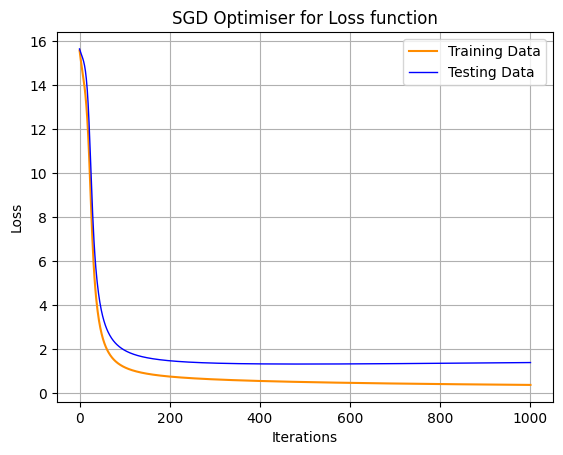

In [94]:
lw = 1
%matplotlib inline
plt.plot(loss_result.index, loss_result['train_loss'], color='darkorange', label='Training Data')
plt.plot(loss_result.index,loss_result['test_loss'], color='blue', linewidth=lw, label='Testing Data')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SGD Optimiser for Loss function')
plt.legend()
plt.grid(True)
plt.show()

### Inspecting the Embeddings
In this section, we take a closer look at the learned embeddings, by

- computing your recommendations
- looking at the nearest neighbors of some movies,
- looking at the norms of the movie embeddings,
- visualizing the embedding in a projected embedding space.

We will compare the following:

- dot product: the score of item j is $\langle u, V_j \rangle$.
- cosine: the score of item j is $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

you can use np.dot to compute the product of two np.Arrays.
you can use np.linalg.norm to compute the norm of a np.Array.

In [98]:
# Optimised movie embeddings
V.numpy()

array([[ 0.4648256 ,  0.3148938 ,  0.11922972, ...,  0.04556944,
         0.19414662,  0.37603816],
       [ 0.3761877 , -0.5462725 ,  0.833188  , ...,  0.4039664 ,
        -0.33280924,  0.6171561 ],
       [ 1.1400373 ,  0.4413067 , -0.96235716, ...,  0.28519687,
        -0.19020543,  0.2430432 ],
       ...,
       [ 0.68923557, -0.45789   ,  0.39066908, ..., -0.46539494,
        -0.6030682 ,  0.415531  ],
       [ 0.46427473,  0.31411093, -0.12962328, ..., -0.19515826,
         0.303185  ,  1.0140117 ],
       [ 0.7005912 ,  0.52951664,  0.03610032, ...,  0.6613713 ,
         1.1422231 ,  0.40841615]], dtype=float32)

In [97]:
# Optimised user embeddings
U.numpy()

array([[ 1.3542126 , -0.2822563 ,  0.556057  , ...,  0.49455115,
         1.0371846 ,  0.21379133],
       [ 0.3980319 , -0.3001165 , -0.526026  , ...,  0.20915602,
         0.29483482,  0.52366716],
       [ 0.52391493, -0.46017507, -0.81470305, ..., -0.25079134,
         0.26542988, -0.61493385],
       ...,
       [ 0.6713481 , -0.1754282 ,  0.74735993, ...,  0.4446521 ,
        -0.7115247 ,  0.28594708],
       [ 0.57115763, -0.2851273 , -0.00310127, ...,  0.19567205,
         0.39744183, -0.5327469 ],
       [ 0.6158463 , -0.94735634, -0.3608884 , ..., -0.15908322,
        -0.11624185,  0.72398335]], dtype=float32)

In [226]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  q = query_embedding
  I = item_embeddings
  if measure == COSINE:
    I = I / np.linalg.norm(I, axis=1, keepdims=True)
    q = q / np.linalg.norm(q)
  scores = q.dot(I.T)
  return scores

In [270]:
def user_recommendations(measure,query_embedding,item_embeddings):
    scores = compute_scores(query_embedding, item_embeddings, measure)
    score_key = measure+"_"+ 'score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    return df

|Similarity Metric | Vector properties considered|
| ----------- | ----------- |
|Euclidean distance| Magnitudes and direction|
|Cosine similarity | Only direction|
|Dot product similarity	| Magnitudes and direction|


Euclidean distance is the straight-line distance between two vectors in a multidimensional space.
This metric is sensitive to scale as well as the vectors' relative location in space. This means that vectors with large values will have a larger Euclidean distance than vectors with small values, even if the vectors are otherwise similar.

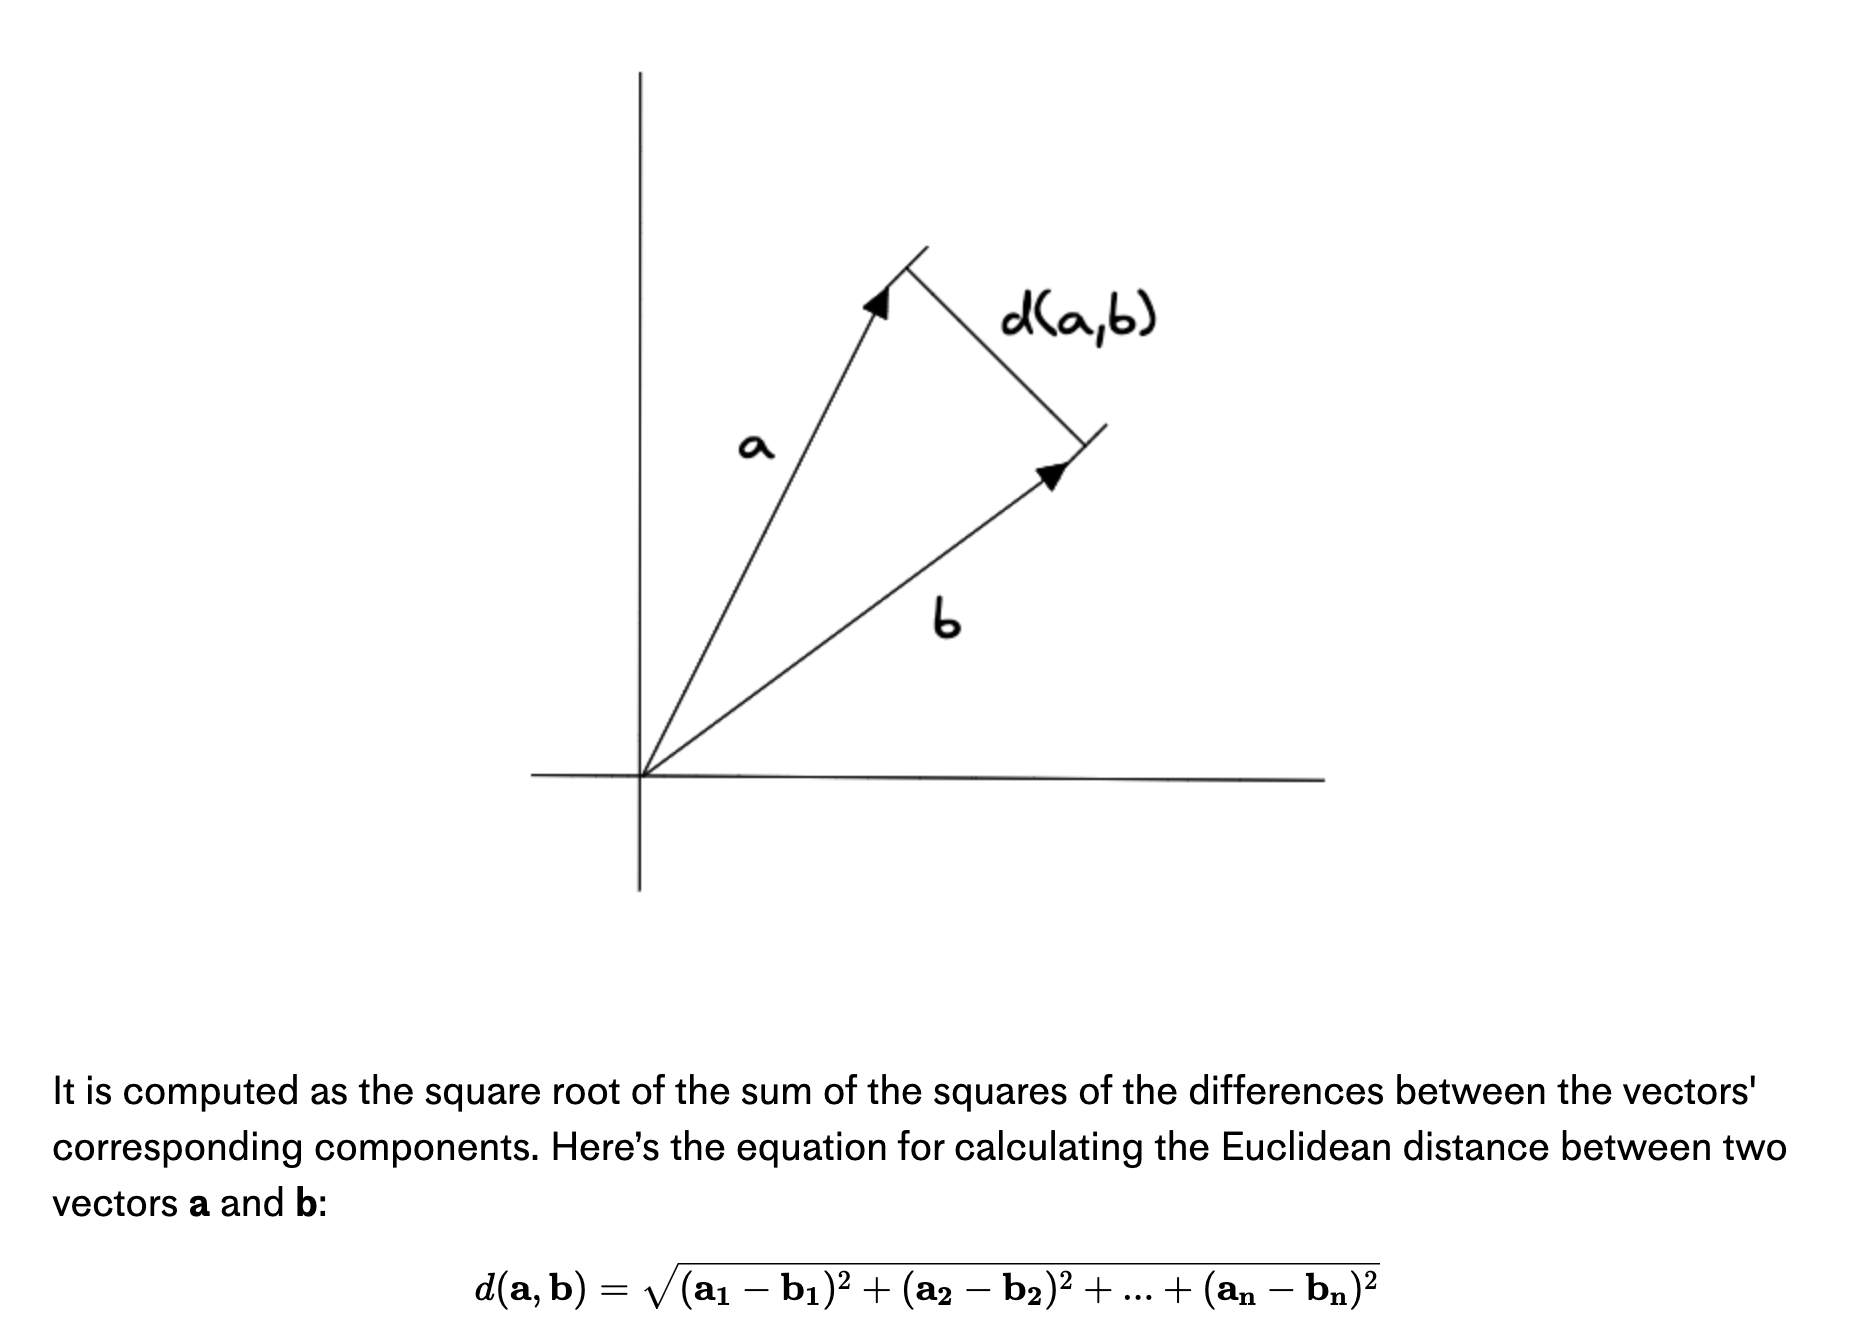

### Recommendations using DOT product
The model is learned such that the dot product between a user embedding and an item(movie) embedding is a good predictor of the rating that user will assign this item. Now, if two products have embeddings with the same direction but different magnitudes, this can mean that the two products are about the same topic, but the one that has a larger magnitude is just better / more popular than the other.


The dot product similarity metric for two vectors is calculated by adding the products of the vectors' corresponding components. The dot product for vectors a and b is calculated as follows:
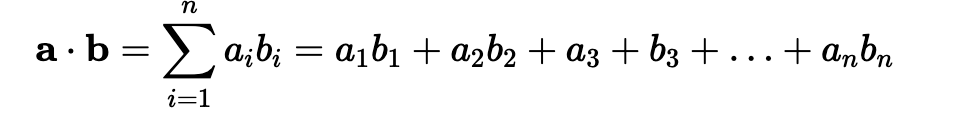
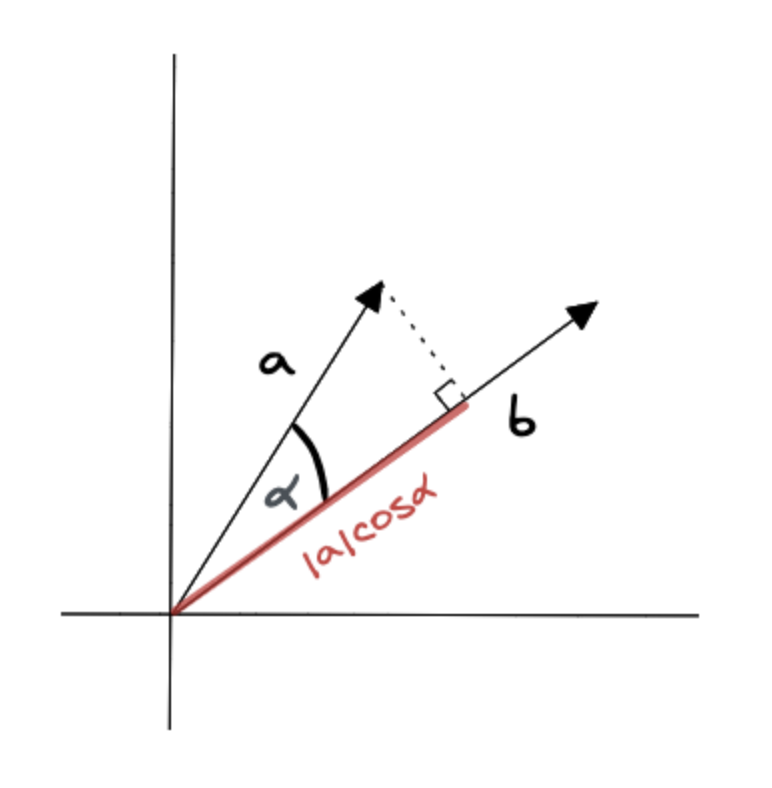

The dot product can also be expressed as the product of the magnitudes of the vectors and the cosine of the angle between them:
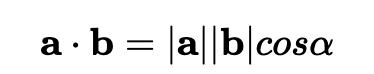

The dot product is a scalar value, which means it is a single number rather than a vector. The dot product is positive if the angle between the vectors is less than 90 degrees, negative if the angle between the vectors is greater than 90 degrees, and zero if the vectors are orthogonal.
The dot product can be affected by the length and direction of the vectors. When two vectors have the same length but different directions, the dot product will be larger if the two vectors are pointing in the same direction and smaller if they are pointing in opposite directions.

In [391]:
# Testing of the recommendations
user_id = 1 # Recommendation for this user
measure=DOT # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U.numpy()[user_id]
item_embeddings = V.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,dot_score,movie_id,titles,genres
958,6.467,958,Dazed and Confused (1993),Comedy
1203,6.123,1203,To Be or Not to Be (1942),Comedy-Drama-War
343,5.767,343,"Apostle, The (1997)",Drama
514,5.670,514,"Boot, Das (1981)",Action-Drama-War
345,5.502,345,Jackie Brown (1997),Crime-Drama
600,5.447,600,For Whom the Bell Tolls (1943),Adventure-War


In [272]:
# Verify if the recommendations are accurate to users historic liking.
movielens[movielens["user_id"] == '1'].sort_values(["rating"],ascending=False).head(5)

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
3928,1,241,5.000,888552084,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,53,F,other,94043
3985,1,310,5.000,888552084,"Wings of the Dove, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Wings+of+the+...,0,0,...,1,0,0,1997,Thriller,Drama-Romance-Thriller,53,F,other,94043
3972,1,284,5.000,888552084,Secrets & Lies (1996),04-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Secrets%20&%2...,0,0,...,0,0,0,1996,Drama,Drama,53,F,other,94043
3976,1,315,5.000,888979693,As Good As It Gets (1997),23-Dec-1997,NaN,http://us.imdb.com/Title?As+Good+As+It+Gets+(1...,0,0,...,0,0,0,1997,Drama,Comedy-Drama,53,F,other,94043
3975,1,282,5.000,888552084,Emma (1996),02-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Emma%20(1996),0,0,...,0,0,0,1996,Drama,Drama-Romance,53,F,other,94043


### Recommendations using COSINE Similarity
Cosine similarity is a measure of the angle between two vectors. It is computed by taking the dot product of the vectors and dividing it by the product of their magnitudes. This metric is not affected by the size of the vector but only by the angle between them. This means that vectors with large or small values will have the same cosine similarity as long as they point in the same direction. Here’s how cosine similarity is calculated for vectors a and b:
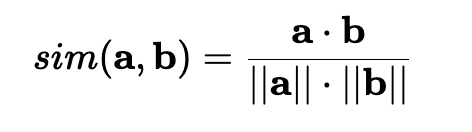

where a and b are the vectors being compared, “•” stands for the dot product, and ||a|| and ||b|| stand for the vectors' lengths. The cosine similarity is between -1 and 1, where 1 means an angle of 0 (vectors are as close as they can be), 0 means orthogonal, and -1 means that the vectors are pointing in opposite directions.

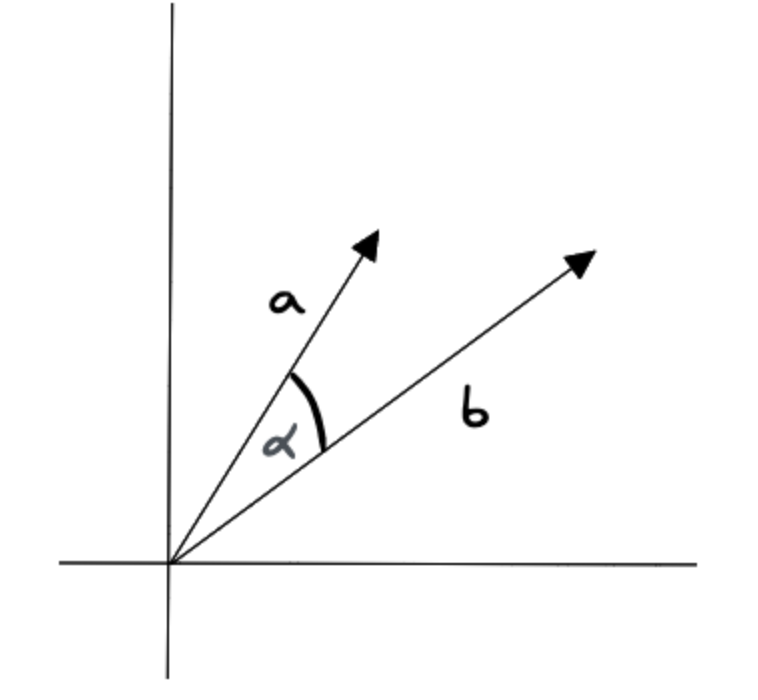

First, the equation calculates the dot product of the vectors by multiplying their components and adding the results. The dot product is then divided by the product of the magnitudes of the vectors, which is calculated by taking the square root of the sum of the squares of the components of the vectors.

If the model was trained using cosine similarity, you either use cosine similarity or normalize and use dot product. Note that options are mathematically equivalent. In some cases normalizing and using the dot product is better, and in some cases where using cosine similarity is better.

Cosine similarity is probably not suitable when you have data where the magnitude of the vectors is important and should be taken into account when determining similarity. For example, it is not appropriate for comparing the similarity of image embeddings based on pixel intensities.

In [390]:
# Testing of the recommendations
user_id = 1 # Recommendation for this user
measure=COSINE # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
query_embedding = U.numpy()[user_id]
item_embeddings = V.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,cosine_score,movie_id,titles,genres
215,0.759,215,When Harry Met Sally... (1989),Comedy-Romance
53,0.713,53,Outbreak (1995),Action-Drama-Thriller
958,0.705,958,Dazed and Confused (1993),Comedy
274,0.704,274,Sense and Sensibility (1995),Drama-Romance
404,0.684,404,Mission: Impossible (1996),Action-Adventure-Mystery
683,0.678,683,In the Line of Fire (1993),Action-Thriller


### Movie Nearest neighbors (Search)

In [279]:
def movie_neighbours(title_substring, measure,k,query_embedding,item_embeddings):
    # Select the most matching title
    ids =  movies[movies['title'].str.contains(title_substring)].index.values
    titles = movies.iloc[ids]['title'].values
    if len(titles) == 0:
        raise ValueError("Found no movies with title %s" % title_substring)
    print("Nearest neighbors of : %s." % titles[0])
    if len(titles) > 1:
        print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))

    movie_id = ids[0]
    query_embedding = query_embedding[movie_id]
    # Calculating dot matrix this the most matched movie with other movie embeddings to find the other matching movies
    scores = compute_scores(query_embedding, item_embeddings, measure)
    score_key = measure+"_"+ 'score'

    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    return df

In [280]:
title_substring="Black" # String to find
measure=DOT # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V.numpy()
item_embeddings = V.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black (1997).
[Found more than one matching movie. Other candidates: Black Sheep (1996), Black Beauty (1994), Fear of a Black Hat (1993)]


,dot_score,movie_id,titles,genres
600,5.614,600,For Whom the Bell Tolls (1943),Adventure-War
317,5.549,317,Schindler's List (1993),Drama-War
256,5.458,256,Men in Black (1997),Action-Adventure-Comedy-Sci-Fi
312,5.413,312,Titanic (1997),Action-Drama-Romance
407,5.245,407,"Close Shave, A (1995)",Animation-Comedy-Thriller
21,5.124,21,Braveheart (1995),Action-Drama-War


In [281]:
title_substring="Black" # String to find
measure=COSINE # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V.numpy()
item_embeddings = V.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black (1997).
[Found more than one matching movie. Other candidates: Black Sheep (1996), Black Beauty (1994), Fear of a Black Hat (1993)]


,cosine_score,movie_id,titles,genres
256,1.000,256,Men in Black (1997),Action-Adventure-Comedy-Sci-Fi
317,0.868,317,Schindler's List (1993),Drama-War
124,0.851,124,Phenomenon (1996),Drama-Romance
264,0.836,264,"Hunt for Red October, The (1990)",Action-Thriller
209,0.823,209,Indiana Jones and the Last Crusade (1989),Action-Adventure
299,0.821,299,Air Force One (1997),Action-Thriller


In [283]:
movielens[movielens["movie_id"].isin(['256','317','124'])].sort_values(["movie_id","rating"],ascending=False).head(10)

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
520,270,317,5.000,885848707,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,51,M,engineer,22932
809,200,317,5.000,884111269,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,27,M,writer,E2A4H
2835,203,317,5.000,892513819,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,52,F,librarian,10960
3425,143,317,5.000,888105419,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,53,M,programmer,20910
4392,11,317,5.000,879960826,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,28,F,other,06405
4636,531,317,5.000,893119439,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,20,M,student,92705
5521,415,317,5.000,893213549,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,20,F,student,92626
7062,491,317,5.000,879969878,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,57,M,educator,94618
7167,206,317,5.000,877124871,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,39,M,marketing,92037
8163,248,317,5.000,879572256,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,1,0,1993,War,Drama-War,25,M,student,84103


It seems that the quality of learned embeddings may not be very good. This will be addressed in Section V by adding several regularization techniques. First, we will further inspect the embeddings.

## Regularisation 
We can also observe that the recommendations with dot-product and cosine are different: with dot-product, the model tends to recommend popular movies. This can be explained by the fact that in matrix factorization models, the norm of the embedding is often correlated with popularity (popular movies have a larger norm), which makes it more likely to recommend more popular items. We can confirm this hypothesis by sorting the movies by their embedding norm, as done in the next cell.

In [286]:
def movie_embedding_norm(movie_embedding):
    df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
    })
    i=0
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(movie_embedding, axis=1)
    return df

In [288]:
movie_embedding=V.numpy()
df=movie_embedding_norm(movie_embedding)

In [289]:
df.sort_values(["norm0","num_ratings"],ascending=False)

,title,genre,num_ratings,norm0
370,"Bridges of Madison County, The (1995)",Drama,67,3.999
1007,I Shot Andy Warhol (1996),Drama,37,3.979
1021,"Fast, Cheap & Out of Control (1997)",Documentary,32,3.965
883,Year of the Horse (1997),Documentary,7,3.906
887,One Night Stand (1997),Drama,15,3.892
...,...,...,...,...
1488,Chasers (1994),Comedy,5,2.042
1411,Land Before Time III: The Time of the Great Gi...,Children's,6,2.026
861,Jingle All the Way (1996),Adventure,18,2.019
1256,"Designated Mourner, The (1997)",Drama,4,2.014


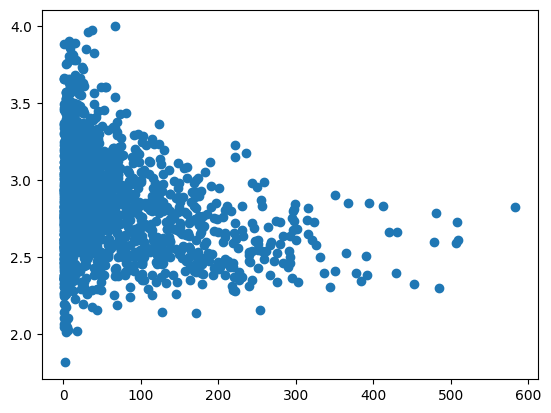

In [290]:
plt.scatter(df['num_ratings'], df['norm0'],)
plt.show()

Note: Depending on how the model is initialized, one may observe that some niche movies (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that movie happens to be initialized with a high norm. Then, because the movie has few ratings, it is infrequently updated, and can keep its high norm. This will be alleviated by using regularization.
Try changing the value of the hyper-parameter `init_stddev`. One quantity that can be helpful is that the expected norm of a $d$-dimensional vector with entries $\sim \mathcal N(0, \sigma^2)$ is approximatley $\sigma \sqrt d$.

In [267]:
loss_result_lowinit,opt_emb_lowinit,U_lowinit,V_lowinit = train(num_iterations=1000,learning_rate=10,init_stddev=0.05,embedding_dim=30)

num_iterations: 1000


In [357]:
loss_result_lowinit

,train_loss,test_loss,learning_rate
0,13.721,13.781,10.000
1,13.720,13.781,10.000
2,13.719,13.781,10.000
3,13.718,13.781,10.000
4,13.717,13.781,10.000
...,...,...,...
996,0.355,0.963,10.000
997,0.355,0.964,10.000
998,0.355,0.964,10.000
999,0.355,0.964,10.000


Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'SGD Optimiser for Loss function with lowered standard deviation')

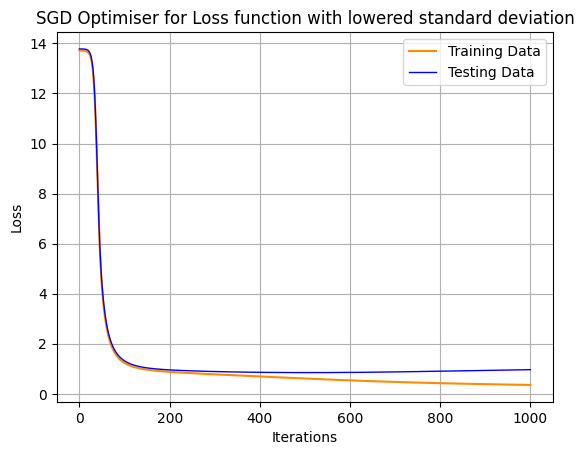

In [269]:
lw = 1
%matplotlib inline
plt.plot(loss_result_lowinit.index, loss_result_lowinit['train_loss'], color='darkorange', label='Training Data')
plt.plot(loss_result_lowinit.index,loss_result_lowinit['test_loss'], color='blue', linewidth=lw, label='Testing Data')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SGD Optimiser for Loss function with lowered standard deviation')
plt.legend()
plt.grid(True)
plt.show()

In [273]:
# Testing of the recommendations
user_id = 1 # Recommendation for this user
measure=DOT # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U_lowinit.numpy()[user_id]
item_embeddings = V_lowinit.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,dot_score,movie_id,titles,genres
49,5.353,49,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
177,5.158,177,12 Angry Men (1957),Drama
184,5.139,184,Psycho (1960),Horror-Romance-Thriller
126,5.084,126,"Godfather, The (1972)",Action-Crime-Drama
426,5.029,426,To Kill a Mockingbird (1962),Drama
479,5.018,479,North by Northwest (1959),Comedy-Thriller


In [276]:
# Verify if the recommendations are accurate to users historic liking.
movielens[movielens["user_id"] == '1'].sort_values(["rating"],ascending=False).head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
3928,1,241,5.000,888552084,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,53,F,other,94043
3985,1,310,5.000,888552084,"Wings of the Dove, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Wings+of+the+...,0,0,...,1,0,0,1997,Thriller,Drama-Romance-Thriller,53,F,other,94043
3972,1,284,5.000,888552084,Secrets & Lies (1996),04-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Secrets%20&%2...,0,0,...,0,0,0,1996,Drama,Drama,53,F,other,94043
3976,1,315,5.000,888979693,As Good As It Gets (1997),23-Dec-1997,NaN,http://us.imdb.com/Title?As+Good+As+It+Gets+(1...,0,0,...,0,0,0,1997,Drama,Comedy-Drama,53,F,other,94043
3975,1,282,5.000,888552084,Emma (1996),02-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Emma%20(1996),0,0,...,0,0,0,1996,Drama,Drama-Romance,53,F,other,94043


In [277]:
# Testing of the recommendations
user_id = 1 # Recommendation for this user
measure=COSINE # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U_lowinit.numpy()[user_id]
item_embeddings = V_lowinit.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,cosine_score,movie_id,titles,genres
765,0.930,765,Man of the Year (1995),Documentary
112,0.897,112,"Horseman on the Roof, The (Hussard sur le toit...",Drama
953,0.895,953,Unzipped (1995),Documentary
177,0.893,177,12 Angry Men (1957),Drama
962,0.893,962,Some Folks Call It a Sling Blade (1993),Drama-Thriller
118,0.891,118,Maya Lin: A Strong Clear Vision (1994),Documentary


In [285]:
title_substring="Black" # String to find
measure=DOT # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V_lowinit.numpy()
item_embeddings = V_lowinit.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black (1997).
[Found more than one matching movie. Other candidates: Black Sheep (1996), Black Beauty (1994), Fear of a Black Hat (1993)]


,dot_score,movie_id,titles,genres
256,7.658,256,Men in Black (1997),Action-Adventure-Comedy-Sci-Fi
180,5.633,180,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
171,5.620,171,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
301,5.594,301,L.A. Confidential (1997),Crime-Film-Noir-Mystery-Thriller
49,5.479,49,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
236,5.464,236,Jerry Maguire (1996),Drama-Romance


In [284]:
title_substring="Black" # String to find
measure=COSINE # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V_lowinit.numpy()
item_embeddings = V_lowinit.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black (1997).
[Found more than one matching movie. Other candidates: Black Sheep (1996), Black Beauty (1994), Fear of a Black Hat (1993)]


,cosine_score,movie_id,titles,genres
256,1.000,256,Men in Black (1997),Action-Adventure-Comedy-Sci-Fi
750,0.762,750,Tomorrow Never Dies (1997),Action-Romance-Thriller
203,0.747,203,Back to the Future (1985),Comedy-Sci-Fi
1429,0.741,1429,Ill Gotten Gains (1997),Drama
289,0.739,289,Fierce Creatures (1997),Comedy
831,0.738,831,Bogus (1996),Children's-Drama-Fantasy


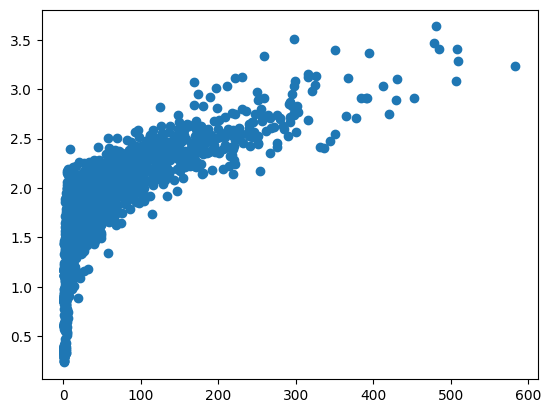

In [292]:
movie_embedding=V_lowinit.numpy()
df=movie_embedding_norm(movie_embedding)
plt.scatter(df['num_ratings'], df['norm0'],)
plt.show()

## Embedding visualization
Since it is hard to visualize embeddings in a higher-dimensional space (when the embedding dimension $k > 3$), one approach is to project the embeddings to a lower dimensional space. T-SNE (T-distributed Stochastic Neighbor Embedding) is an algorithm that projects the embeddings while attempting to preserve their pariwise distances. It can be useful for visualization, but one should use it with care. For more information on using t-SNE, see [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/).

In [296]:
def tsne_movie_embeddings(movie_embedding):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(movie_embedding)
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return movies

In [298]:
movie_embedding = V_lowinit
df=tsne_movie_embeddings(movie_embedding)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.051354
[t-SNE] KL divergence after 50 iterations with early exaggeration: 55.393044
[t-SNE] KL divergence after 400 iterations: 2.221560


In [300]:
df

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,x,y
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,1995,Children's,Animation-Children's-Comedy,-2.451,9.525
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,1,0,0,1995,Thriller,Action-Adventure-Thriller,-14.968,-4.451
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,1,0,0,1995,Thriller,Thriller,-13.455,-8.328
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama,7.014,6.594
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,1,0,0,1995,Thriller,Crime-Drama-Thriller,-7.245,1.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,1998,Drama,Drama,-1.586,7.951
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,1,0,1,0,0,1998,Romance,Romance-Thriller,-1.584,7.846
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,1,0,0,0,0,1998,Drama,Drama-Romance,-1.750,7.699
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,1994,Comedy,Comedy,3.610,7.952


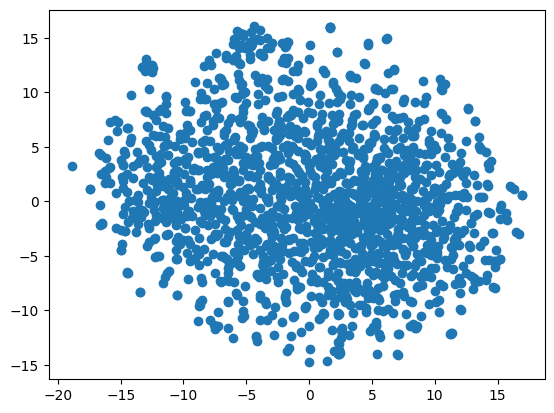

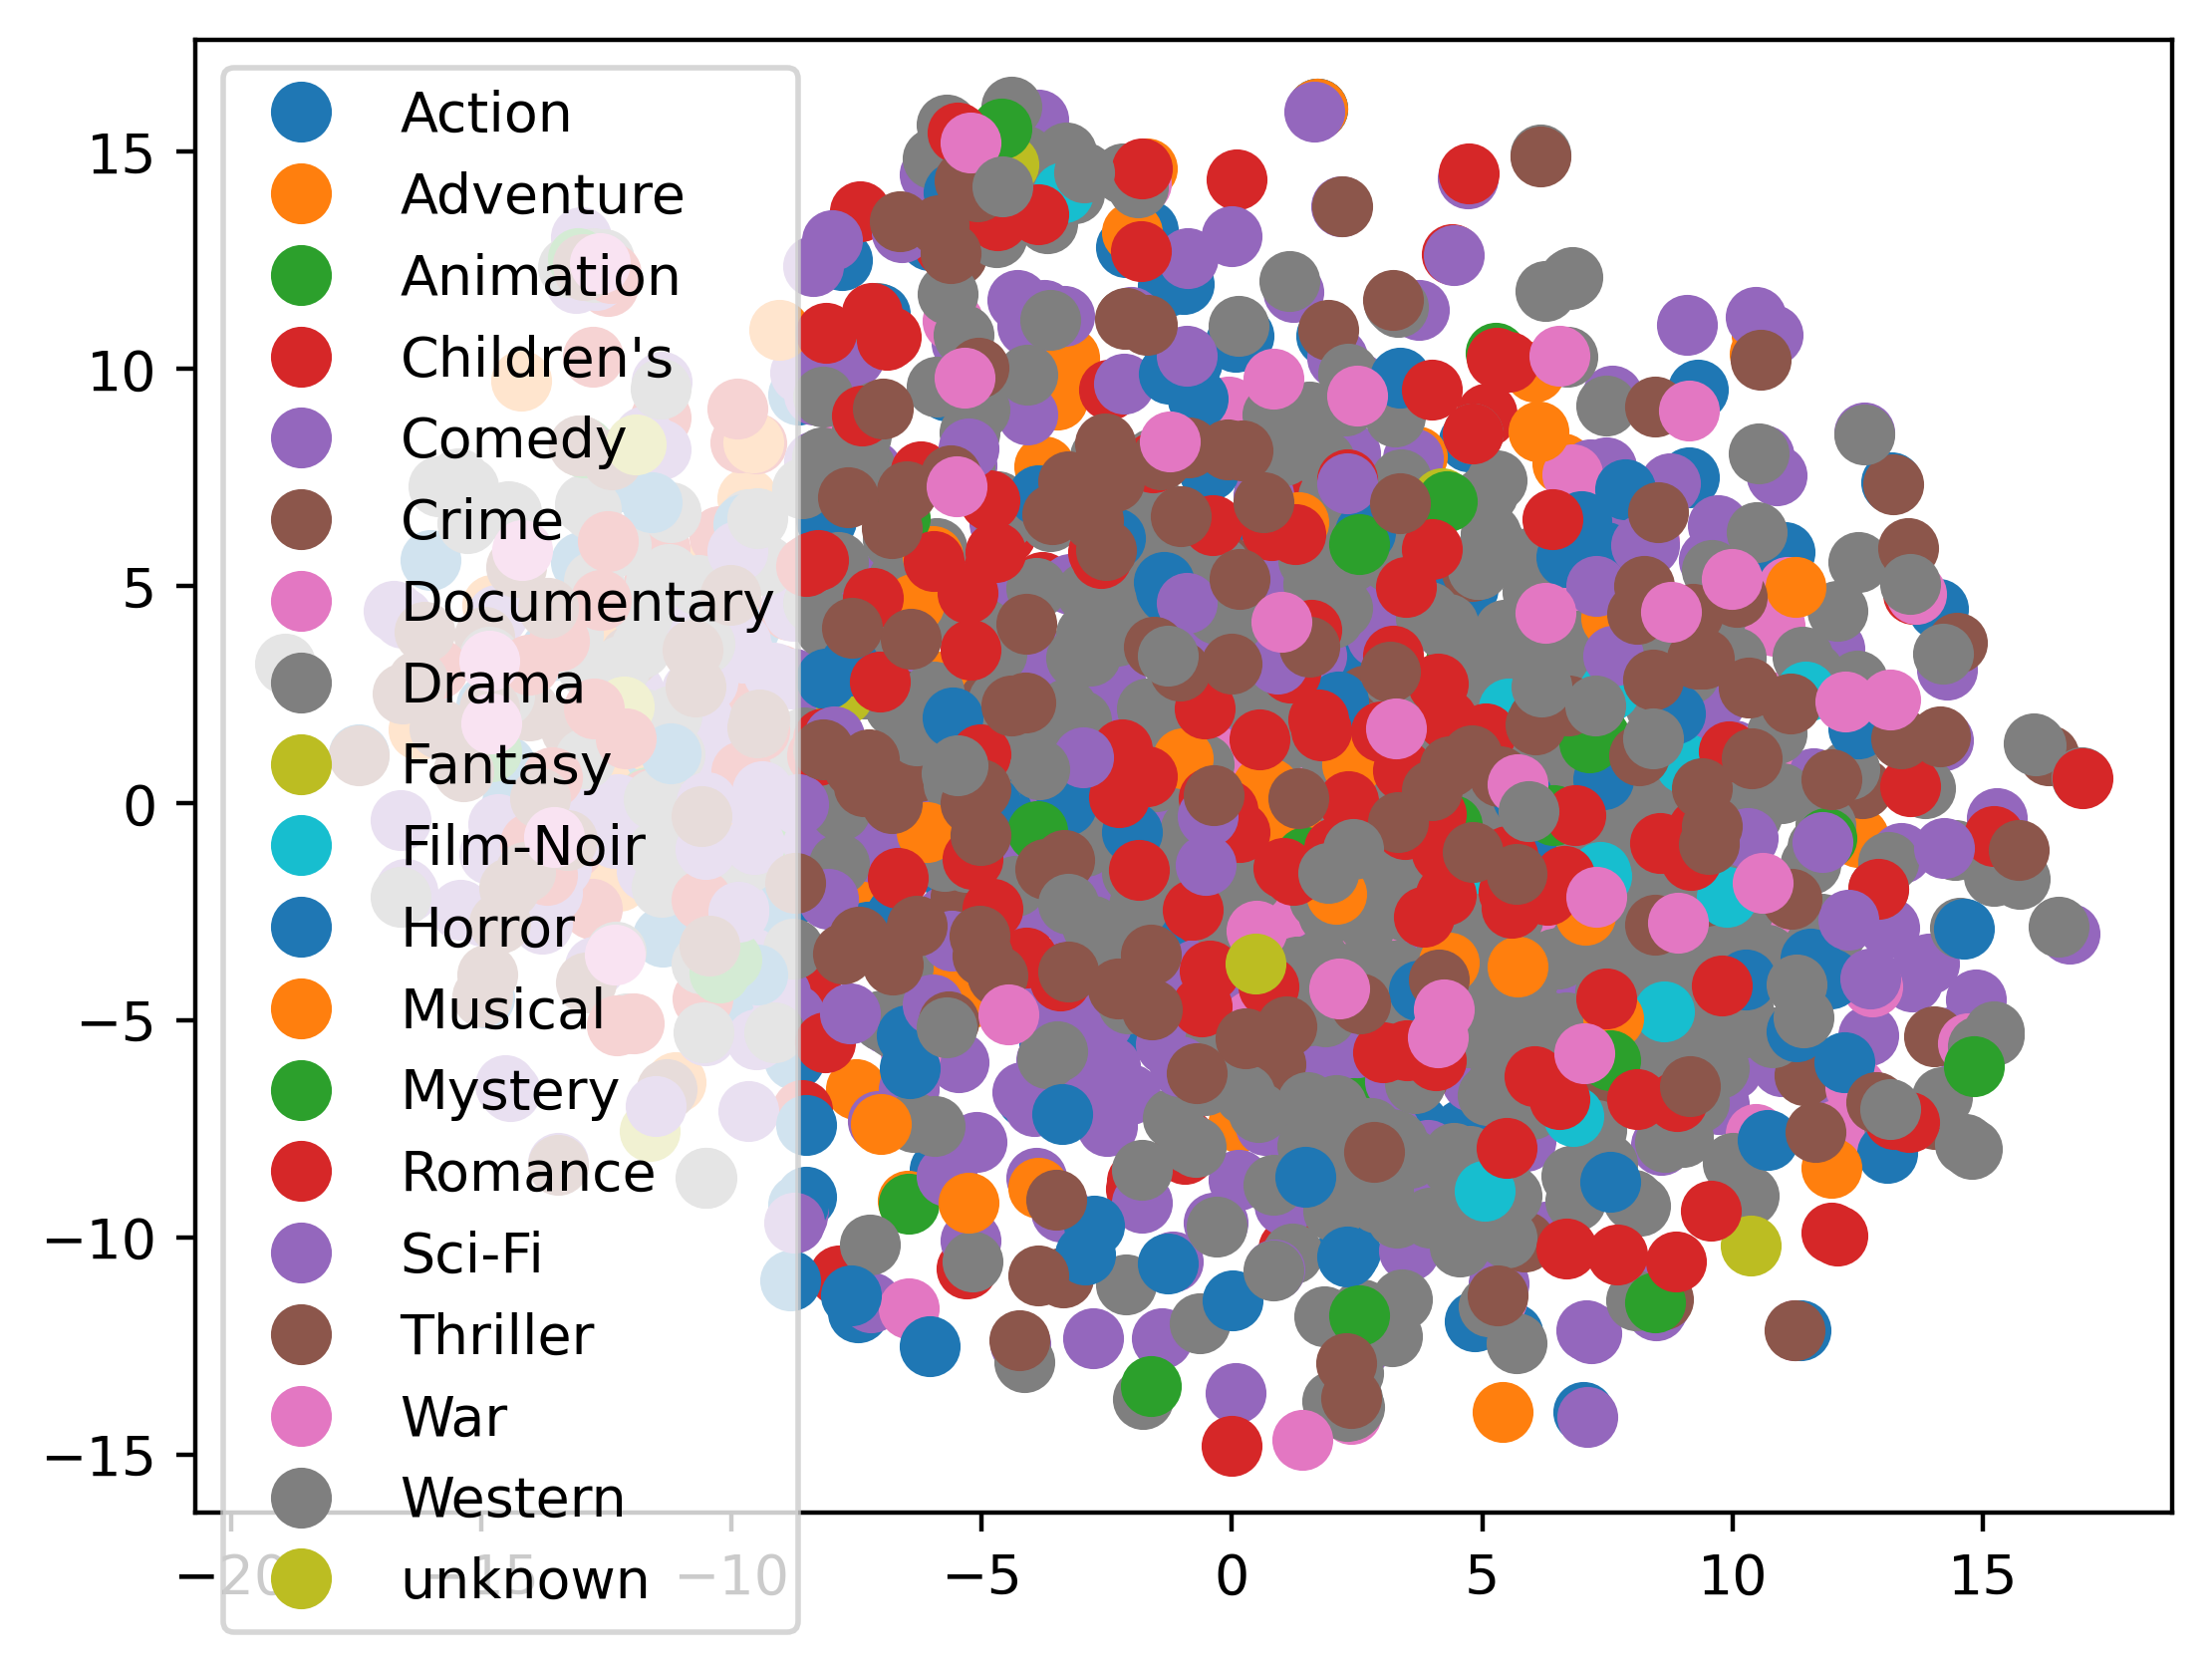

In [306]:
plt.scatter(df['x'], df['y'],)
labels = movies['genre'].unique()
groups = df.groupby('genre')

# Plot
fig, ax = plt.subplots()
fig.set_dpi(400)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name)
ax.legend()

plt.show()

We can observe that the embeddings do not seem to have any notable structure, and the embeddings of a given genre are located all over the embedding space. This confirms the poor quality of the learned embeddings. One of the main reasons, which we will address in the next section, is that we only trained the model on observed pairs, and without regularization.

# V. Regularization In Matrix Factorization

In the previous section, our loss was defined as the mean squared error on the observed part of the rating matrix.  This can be problematic as the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as *folding*.

We will add regularization terms that will address this issue. We will use two types of regularization:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

The total loss is then given by
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

In [319]:
U.shape[0]

943

In [321]:
V.shape[0]

1682

In [322]:
# @title Solution
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

In [371]:
def build_train_regularised_model(gravity_coeff, init_stddev,embedding_dim,regularization_coeff,num_iterations=1,learning_rate=1.0,optimizer=tf.keras.optimizers.legacy.SGD):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[0], embedding_dim]))
  V = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[1], embedding_dim]))
  loss_result = pd.DataFrame(columns =['train_loss', 'test_loss','learning_rate','gravity_loss','regularization_loss'])

  for i in range(num_iterations + 1):
        # print("\r iteration %d: " % i )
        # print("learning_rate: " + str(learning_rate))
        opt = optimizer(learning_rate)
        with tf.GradientTape() as tape:
          train_loss = sparse_mean_square_error_observed_pairs_only(A_train,U,V)
          test_loss = sparse_mean_square_error_observed_pairs_only(A_test,U,V)

          gravity_loss = gravity_coeff * gravity(U, V)

          regularization_loss = regularization_coeff * (
            tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])

          loss_result.loc[i] = [train_loss.numpy(), test_loss.numpy(),learning_rate,gravity_loss.numpy(),regularization_loss.numpy()]
        # Compute the gradients for a list of variables.
        grads = tape.gradient(train_loss, [U,V])
        # Ask the optimizer to apply the gradients on variables.
        opt_emb = opt.apply_gradients(zip(grads,[U, V]))

        # learning_rate = learning_rate/10
  total_loss = train_loss + regularization_loss + gravity_loss

  losses = {
              'train_error_observed': train_loss,
              'test_error_observed': test_loss,
          }
  loss_components = {
              'observed_loss': train_loss,
              'regularization_loss': regularization_loss,
              'gravity_loss': gravity_loss,
          }
  return loss_result,opt_emb,U,V,total_loss,losses,loss_components

In [372]:
loss_result_reg,opt_emb_reg,U_reg,V_reg,total_loss,losses,loss_components=build_train_regularised_model(num_iterations=2000, learning_rate=20,optimizer=tf.keras.optimizers.legacy.SGD,regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)

In [373]:
loss_result_reg

,train_loss,test_loss,learning_rate,gravity_loss,regularization_loss
0,13.729,13.707,20.000,0.000,0.017
1,13.727,13.708,20.000,0.000,0.017
2,13.725,13.708,20.000,0.000,0.017
3,13.723,13.708,20.000,0.000,0.018
4,13.721,13.707,20.000,0.000,0.018
...,...,...,...,...,...
1996,0.142,1.530,20.000,9.506,1.448
1997,0.142,1.530,20.000,9.507,1.448
1998,0.142,1.530,20.000,9.507,1.448
1999,0.142,1.531,20.000,9.507,1.449


In [374]:
total_loss

<tf.Tensor: shape=(), dtype=float32, numpy=11.098108>

In [375]:
losses

{'train_error_observed': <tf.Tensor: shape=(), dtype=float32, numpy=0.14219868>,
 'test_error_observed': <tf.Tensor: shape=(), dtype=float32, numpy=1.5308021>}

In [376]:
loss_components

{'observed_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.14219868>,
 'regularization_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4487814>,
 'gravity_loss': <tf.Tensor: shape=(), dtype=float32, numpy=9.507129>}

In [337]:
# embeddings_reg, A_train,A_test,total_loss, [losses, loss_components] = build_regularized_model(ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)

In [345]:
# loss_result_reg,opt_emb_reg,U_reg,V_reg = train_regularised_model(A_train,A_test,embeddings_reg,num_iterations=2000, learning_rate=20,optimizer=tf.keras.optimizers.legacy.SGD)

Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'SGD Optimiser for Loss function regularised')

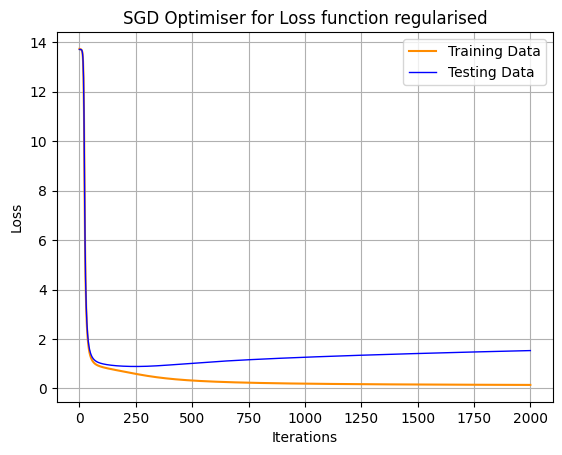

In [377]:
lw = 1
%matplotlib inline
plt.plot(loss_result_reg.index, loss_result_reg['train_loss'], color='darkorange', label='Training Data')
plt.plot(loss_result_reg.index,loss_result_reg['test_loss'], color='blue', linewidth=lw, label='Testing Data')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SGD Optimiser for Loss function regularised')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'SGD Optimiser for Loss function regularised')

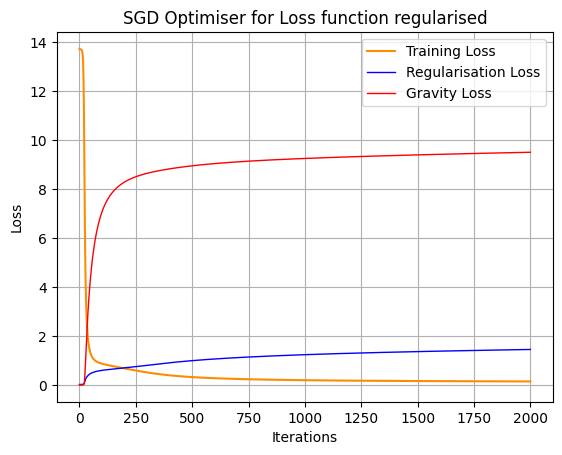

In [378]:
lw = 1
%matplotlib inline
plt.plot(loss_result_reg.index, loss_result_reg['train_loss'], color='darkorange', label='Training Loss')
plt.plot(loss_result_reg.index,loss_result_reg['regularization_loss'], color='blue', linewidth=lw, label='Regularisation Loss')
plt.plot(loss_result_reg.index,loss_result_reg['gravity_loss'], color='red', linewidth=lw, label='Gravity Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SGD Optimiser for Loss function regularised')
plt.legend()
plt.grid(True)
plt.show()

Observe that adding the regularization terms results in a higher MSE, both on the training and test set. However, as we will see, the quality of the recommendations improves. This highlights a tension between fitting the observed data and minimizing the regularization terms. Fitting the observed data often emphasizes learning high similarity (between items with many interactions), but a good embedding representation also requires learning low similarity (between items with few or no interactions).

#### Inspect the results for regularised model

In [379]:
# Testing of the recommendations
user_id = 1 # Recommendation for this user
measure=COSINE # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U_reg.numpy()[user_id]
item_embeddings = V_reg.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,cosine_score,movie_id,titles,genres
802,0.806,802,Heaven & Earth (1993),Action-Drama-War
1642,0.797,1642,Angel Baby (1995),Drama
1417,0.779,1417,"Joy Luck Club, The (1993)",Drama
1195,0.774,1195,"Savage Nights (Nuits fauves, Les) (1992)",Drama
1026,0.764,1026,"Shooter, The (1995)",Action
1329,0.763,1329,An Unforgettable Summer (1994),Drama


In [380]:
# Testing of the recommendations
user_id = 1 # Recommendation for this user
measure=DOT # Use of DOT product or Cosine simialrity
exclude_rated = False # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
# Create the query embeddings
query_embedding = U_reg.numpy()[user_id]
item_embeddings = V_reg.numpy()
df = user_recommendations(measure,query_embedding,item_embeddings)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,dot_score,movie_id,titles,genres
282,6.153,282,Emma (1996),Drama-Romance
675,5.620,675,"Crucible, The (1996)",Drama
314,5.391,314,Apt Pupil (1998),Drama-Thriller
47,5.290,47,Hoop Dreams (1994),Documentary
204,5.273,204,Patton (1970),Drama-War
142,5.215,142,"Sound of Music, The (1965)",Musical


In [381]:
title_substring="Black" # String to find
measure=COSINE # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V_reg.numpy()
item_embeddings = V_reg.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black (1997).
[Found more than one matching movie. Other candidates: Black Sheep (1996), Black Beauty (1994), Fear of a Black Hat (1993)]


,cosine_score,movie_id,titles,genres
256,1.000,256,Men in Black (1997),Action-Adventure-Comedy-Sci-Fi
315,0.742,315,As Good As It Gets (1997),Comedy-Drama
1193,0.736,1193,Once Were Warriors (1994),Crime-Drama
1071,0.722,1071,"Pyromaniac's Love Story, A (1995)",Comedy-Romance
586,0.711,586,"Hour of the Pig, The (1993)",Drama-Mystery
1504,0.711,1504,Killer: A Journal of Murder (1995),Crime-Drama


In [382]:
title_substring="Black" # String to find
measure=DOT # DOT or Cosine Similarity
k=6 # Number of movies to recommend
score_key = measure+"_"+ 'score'
query_embedding = V_reg.numpy()
item_embeddings = V_reg.numpy()
df = movie_neighbours(title_substring,measure,k,query_embedding,item_embeddings)
df.sort_values([score_key], ascending=False).head(k)

Nearest neighbors of : Men in Black (1997).
[Found more than one matching movie. Other candidates: Black Sheep (1996), Black Beauty (1994), Fear of a Black Hat (1993)]


,dot_score,movie_id,titles,genres
256,7.874,256,Men in Black (1997),Action-Adventure-Comedy-Sci-Fi
315,6.091,315,As Good As It Gets (1997),Comedy-Drama
312,5.816,312,Titanic (1997),Action-Drama-Romance
514,5.511,514,"Boot, Das (1981)",Action-Drama-War
342,5.463,342,Alien: Resurrection (1997),Action-Horror-Sci-Fi
269,5.438,269,Gattaca (1997),Drama-Sci-Fi-Thriller


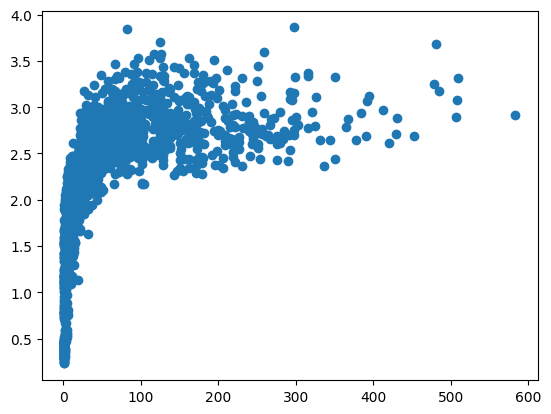

In [385]:
movie_embedding=V_reg.numpy()
df=movie_embedding_norm(movie_embedding)
plt.scatter(df['num_ratings'], df['norm0'],)
plt.show()

In [387]:
movie_embedding = V_reg
df=tsne_movie_embeddings(movie_embedding)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.101526
[t-SNE] KL divergence after 50 iterations with early exaggeration: 55.350502
[t-SNE] KL divergence after 400 iterations: 2.390622


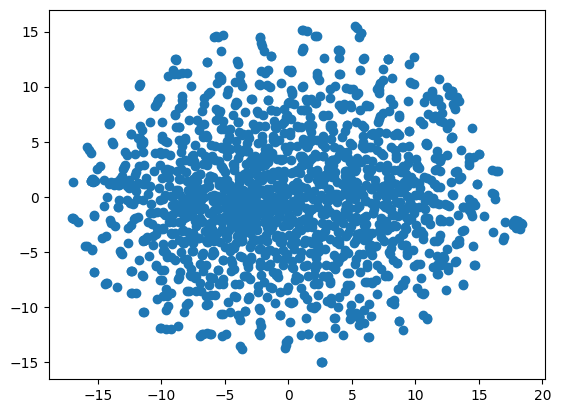

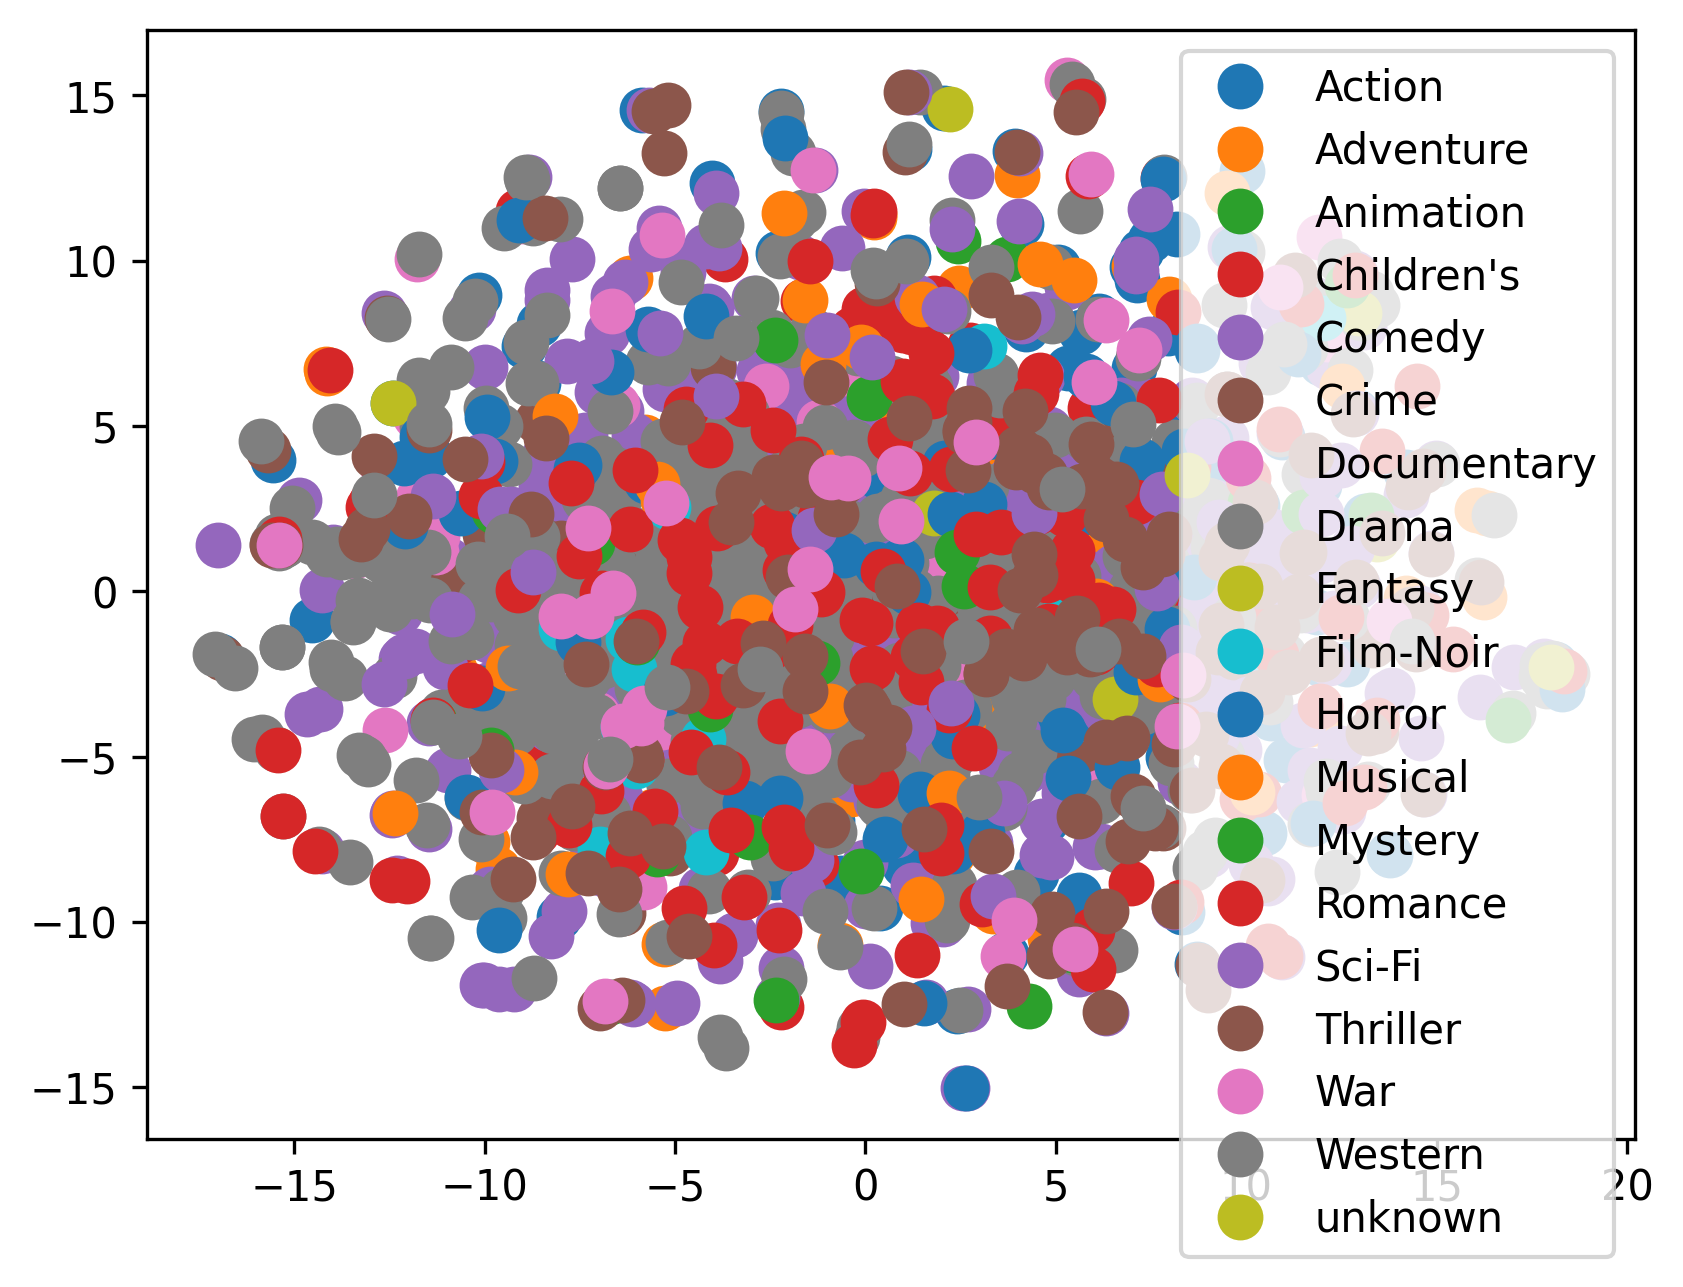

In [388]:
plt.scatter(df['x'], df['y'],)
labels = movies['genre'].unique()
groups = df.groupby('genre')

# Plot
fig, ax = plt.subplots()
fig.set_dpi(300)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name)
ax.legend()

plt.show()

# softmax model that predicts whether a given user has rated a movie
The model will take as input a feature vector  𝑥  representing the list of movies the user has rated. We start from the ratings DataFrame, which we group by user_id.

In [392]:
rated_movies = (ratings[["user_id", "movie_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_movies.head()

,user_id,movie_id
0,0,"[60, 188, 32, 159, 19, 201, 170, 264, 154, 116..."
1,1,"[291, 250, 49, 313, 296, 289, 311, 280, 12, 27..."
2,10,"[110, 557, 731, 226, 424, 739, 722, 37, 724, 1..."
3,100,"[828, 303, 595, 221, 470, 404, 280, 251, 281, ..."
4,101,"[767, 822, 69, 514, 523, 321, 624, 160, 447, 4..."


We then create a function that generates an example batch, such that each example contains the following features:

movie_id: A tensor of strings of the movie ids that the user rated.
genre: A tensor of strings of the genres of those movies
year: A tensor of strings of the release year.

In [393]:
#@title Batch generation code (run this cell)
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}
genres_dict = {
    movie: genres.split('-')
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
      movies rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  movie = []
  year = []
  genre = []
  label = []
  for movie_ids in ratings["movie_id"].values:
    movie.append(movie_ids)
    genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
    year.append([years_dict[movie_id] for movie_id in movie_ids])
    label.append([int(movie_id) for movie_id in movie_ids])
  features = {
      "movie_id": pad(movie, ""),
      "year": pad(year, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))


### Loss function
Recall that the softmax model maps the input features $x$ to a user embedding $\psi(x) \in \mathbb R^d$, where $d$ is the embedding dimension. This vector is then multiplied by a movie embedding matrix $V \in \mathbb R^{m \times d}$ (where $m$ is the number of movies), and the final output of the model is the softmax of the product
$$
\hat p(x) = \text{softmax}(\psi(x) V^\top).
$$
Given a target label $y$, if we denote by $p = 1_y$ a one-hot encoding of this target label, then the loss is the cross-entropy between $\hat p(x)$ and $p$.

In [394]:
# @title Solution
def softmax_loss(user_embeddings, movie_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    movie_embeddings: A tensor of shape [num_movies, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  movie_emb_dim = movie_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))

  logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

In [ ]:
def build_softmax_model(rated_movies, embedding_cols, hidden_dims):
  """Builds a Softmax model for MovieLens.
  Args:
    rated_movies: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_movies, test_rated_movies = split_dataframe(rated_movies)
  train_batch = make_batch(train_rated_movies, 200)
  test_batch = make_batch(test_rated_movies, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    movie_embeddings = tf.get_variable(
        "input_layer/movie_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, movie_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, movie_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"movie_id": movie_embeddings}
  return CFModel(embeddings, train_loss, metrics)